## 感知机

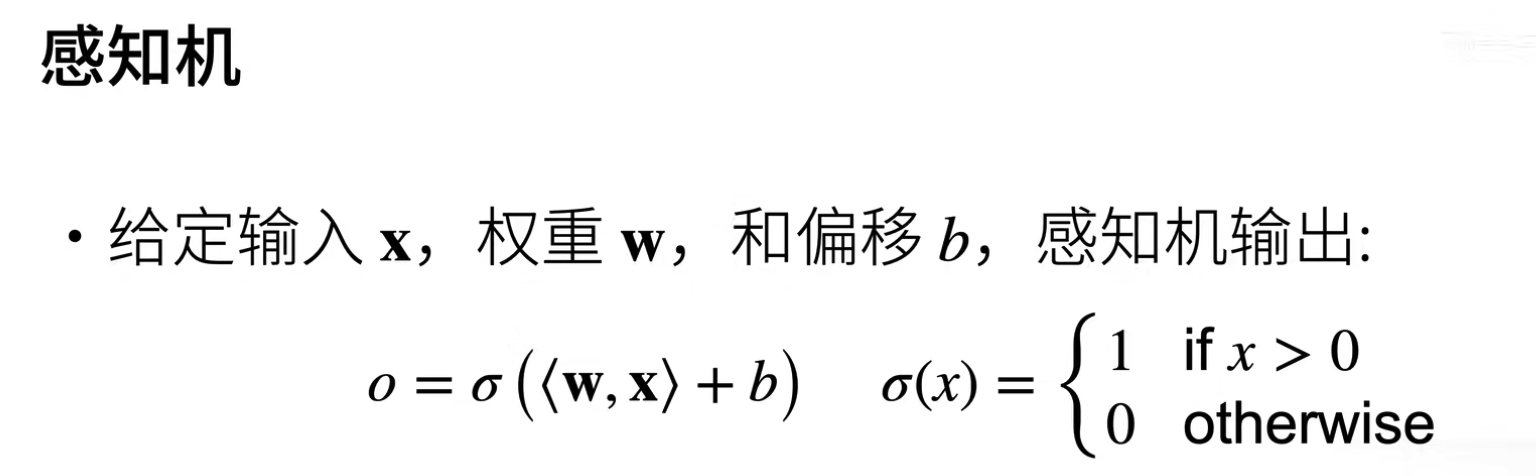
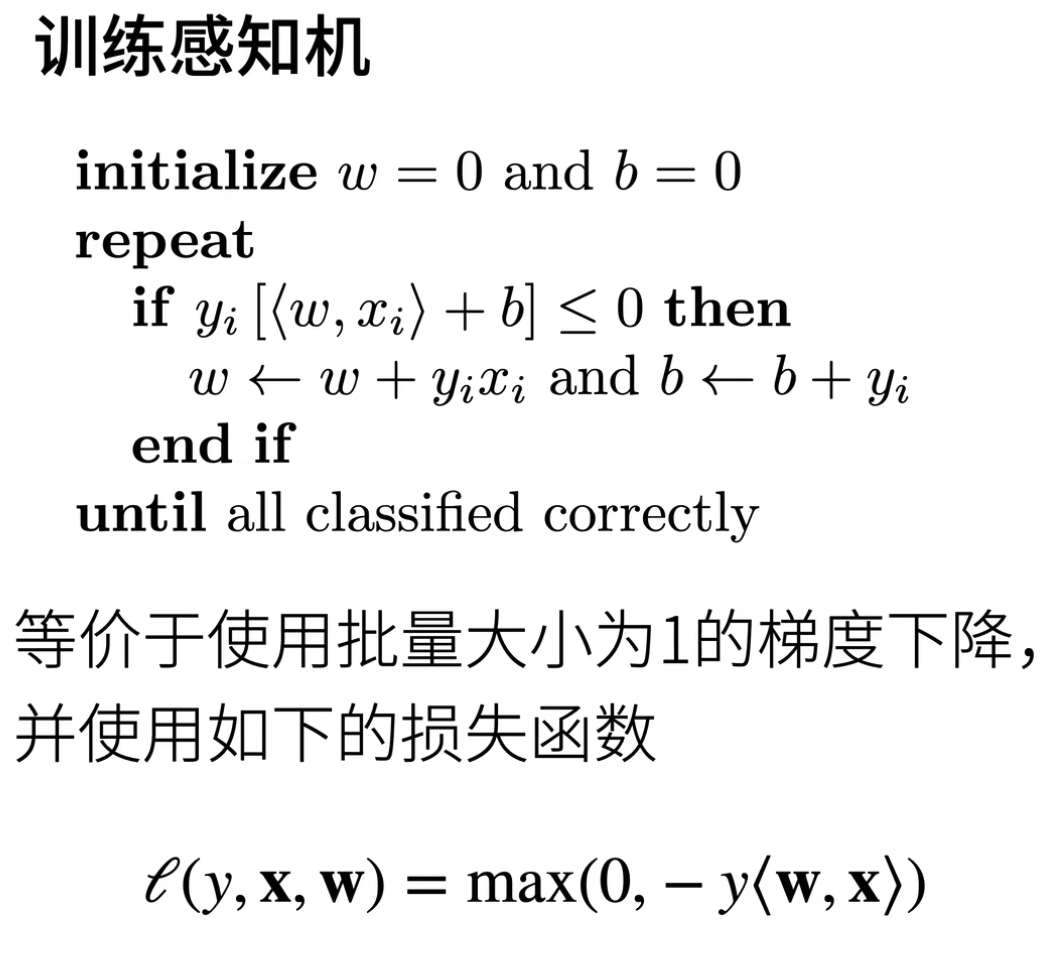
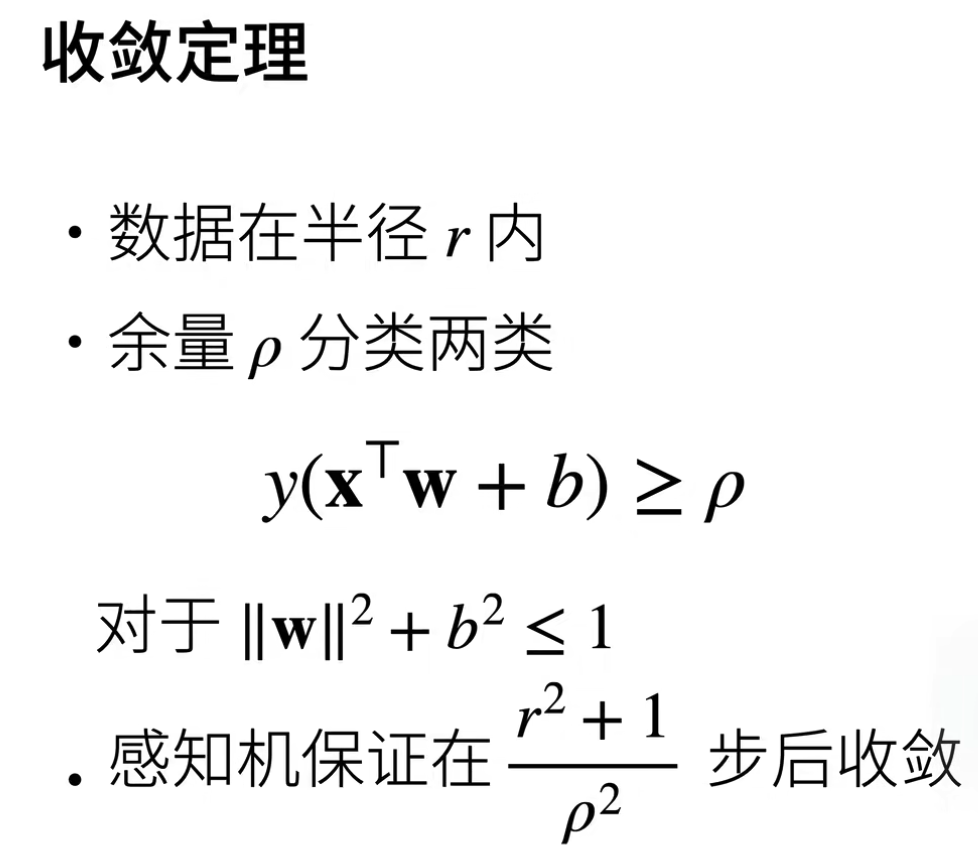


### 感知机存在的问题
- 不能拟合XOR函数，只能产生线性分割面
- XOR问题 需要多层感知机

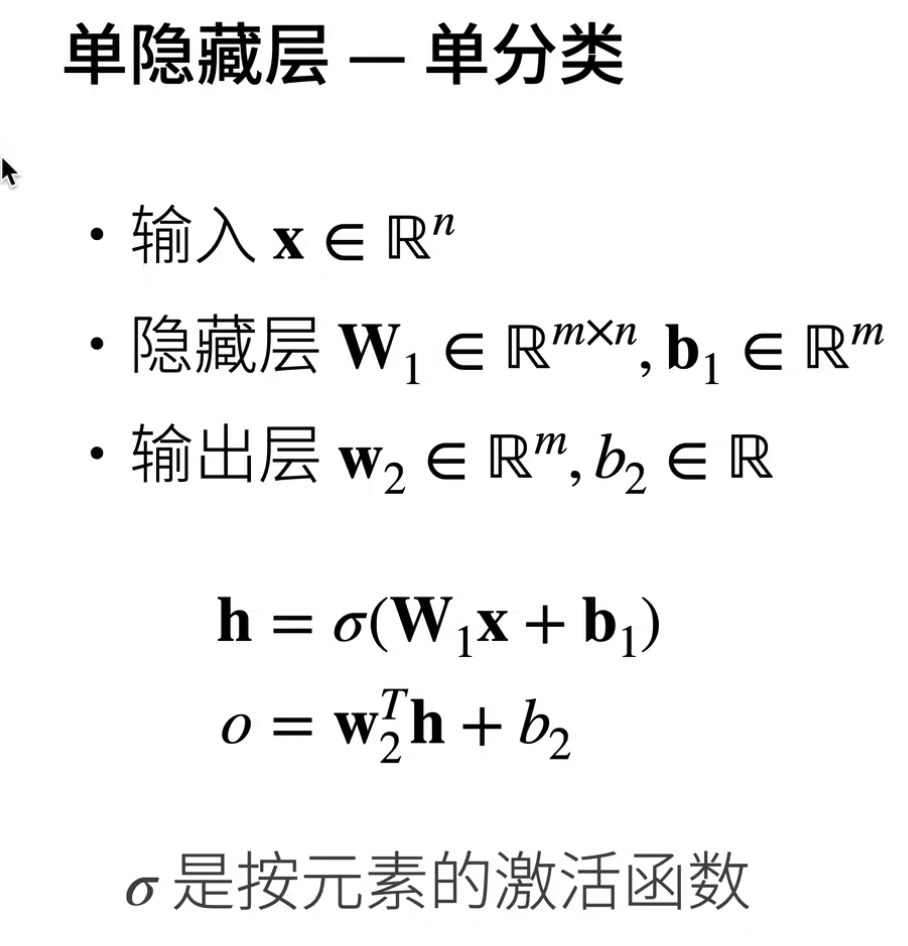

### 非线性激活函数
- 如果不是非线性的激活函数，则相当于最简单的线性模型，线性感知机
- sigmoid 相对比较容易计算导数
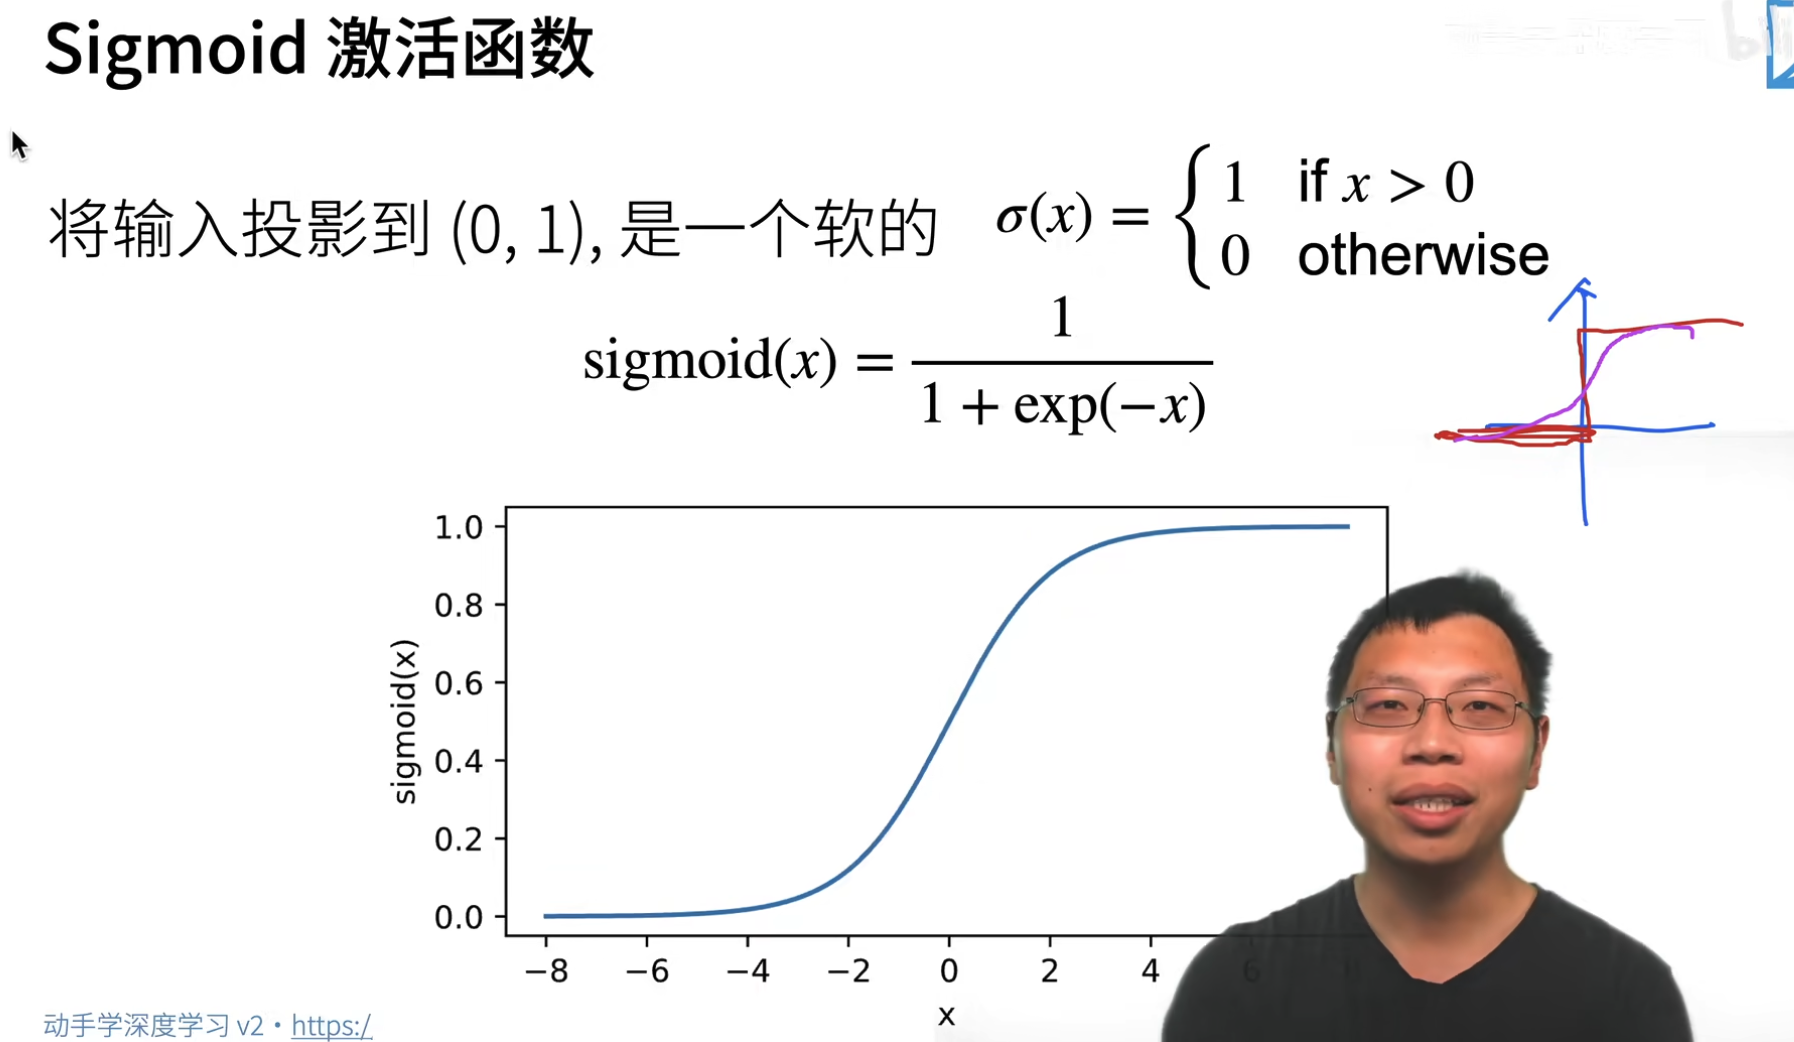
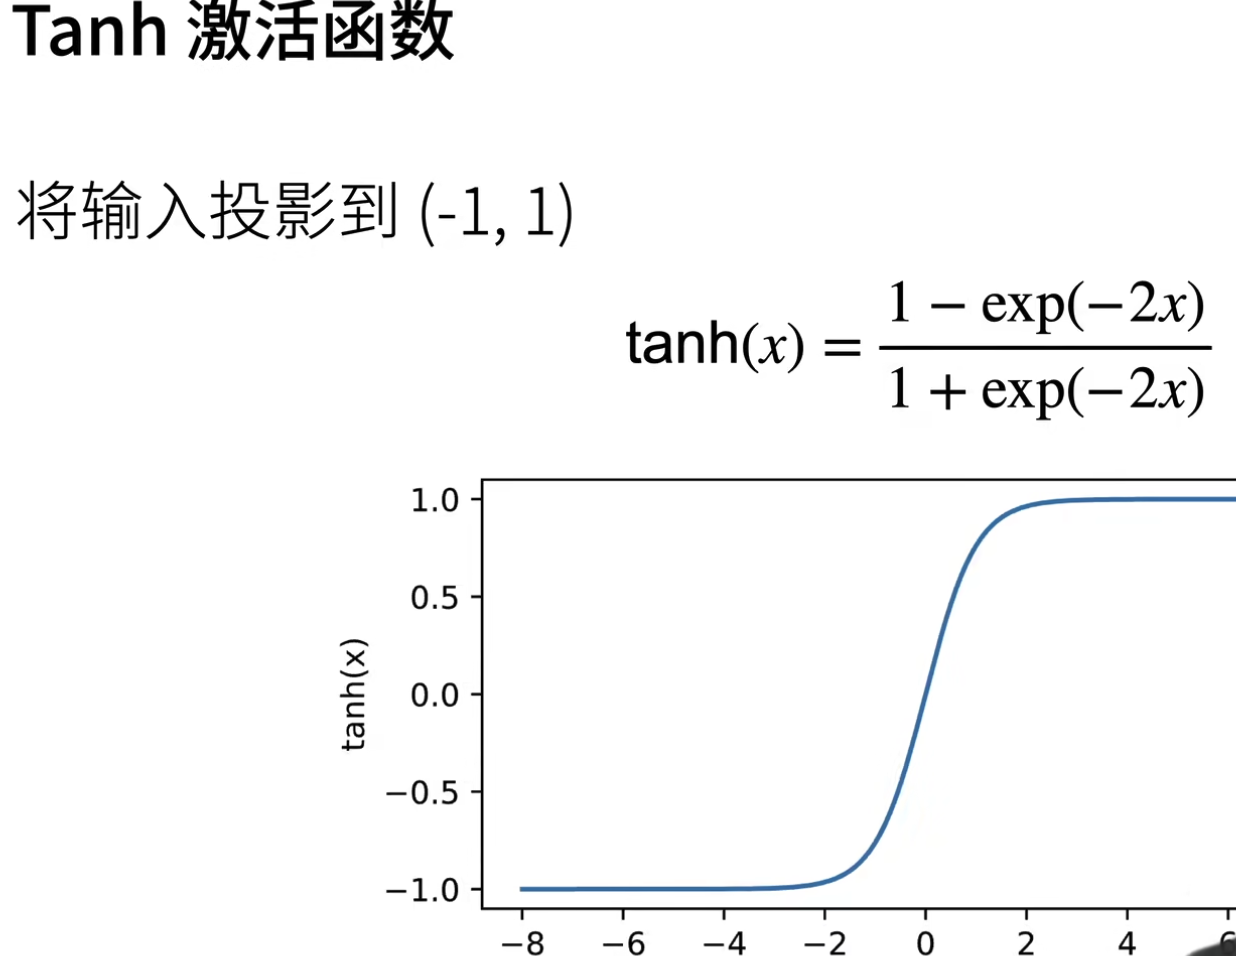

### 多类分类
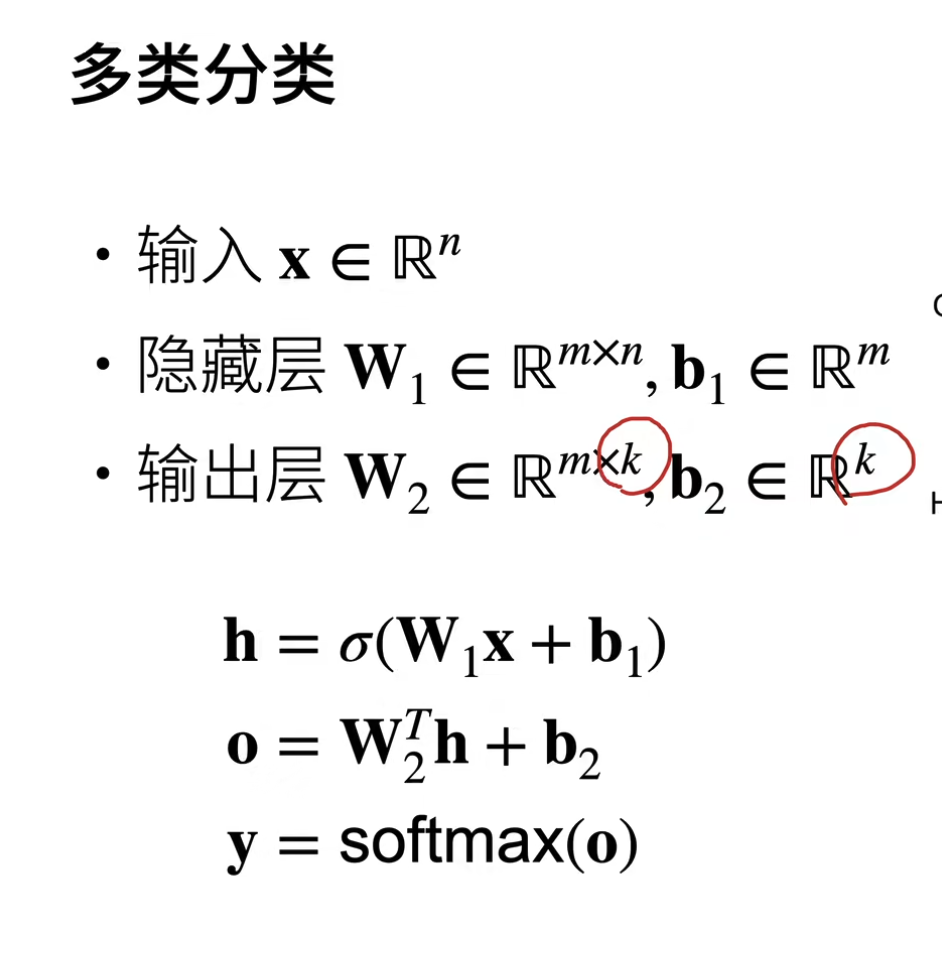



## TIPS

1. 数据比较难，
   - 单隐藏层，隐藏层的大小可以大一些
   - 多个层数，隐藏层的大小开始可以比单隐藏层小一些，然后随着层数逐渐变小
   - 多个层数，第一个隐藏层的大小可以扩一下，然后随着层数逐渐变小

In [89]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l
from IPython import display

d2l.use_svg_display()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


In [90]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

w1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))

w2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [w1, b1, w2, b2]

In [91]:
def relu(x):
    a = torch.zeros_like(x)
    return torch.max(x, a)

In [ ]:
def net(x):
    x = x.reshape((-1, num_inputs))
    h = relu(x @ w1 + b1)
    return (h @ w2 + b2)

# reduction='none' 不对样本的损失值进行聚合，返回每个样本的loss值
loss = nn.CrossEntropyLoss(reduction='none')

In [93]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [94]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [95]:
# 预测正确的数量，不是accuracy
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# accuracy(y_hat, y) / len(y)

In [96]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    for x, y in data_iter:
        metric.add(accuracy(net(x), y), y.numel())
    return metric[0] / metric[1]


In [97]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [98]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

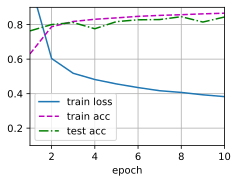

In [99]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [100]:
# 简洁实现

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

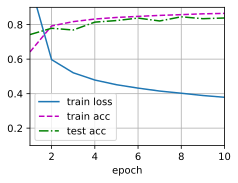

In [101]:
batch_size, lr, num_epochs = 256, 0.1, 10

loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)